## PriorCVAE-2D Visualization

In [1]:
import os
import yaml
import random

import numpy as np
import numpyro
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import flax.linen as nn

from priorCVAE.priors import Matern52, GP
from priorCVAE.datasets import GPDataset
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, create_grid
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model, run_mcmc_gp, gp_mcmc_inference_model

import jax.config as config
config.update("jax_enable_x64", True)


## Loading setup

In [2]:
#output_dir = "../../outputs/15bprzyt"
output_dir = "../../outputs/6xmujvtq"
n_samples = 1000
ls_to_plot = jnp.linspace(0.1, 1, 16)  # 16 is hardcoded as plotting on grid depends on it

#true_ls = 0.3
true_ls = 0.5
kernel = Matern52()

In [3]:
cfg_path = os.path.join(output_dir, "files", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

conditional = cfg_data["conditional"]["value"]
latent_dim = cfg_data["latent_dim"]["value"]
dec_activation_fn = cfg_data["dec_activation"]["value"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

x0 = cfg_data["x0"]["value"]
x1 = cfg_data["x1"]["value"]
n_data = cfg_data["n_data"]["value"]
x_dim = cfg_data["x_dim"]["value"]

In [4]:
def get_vae_samples(decoder, trained_decoder_params, ls, conditional, n=1000):
    key = jax.random.PRNGKey(random.randint(0, 9999))
    rng, z_rng = jax.random.split(key, 2)
    z = jax.random.normal(z_rng, (n, latent_dim))
    if conditional:
        c = ls * jnp.ones((z.shape[0], 1))
        z = jnp.concatenate([z, c], axis=-1)
        
    vae_samples = decoder.apply({'params': trained_decoder_params}, z)
    
    return vae_samples

In [5]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]

In [6]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [7]:
x = create_grid(n_data, x0, x1, x_dim)
data_generator = GPDataset(kernel=kernel, x=x, sample_lengthscale=False)

## Plot Marginals and Empirical Covariance

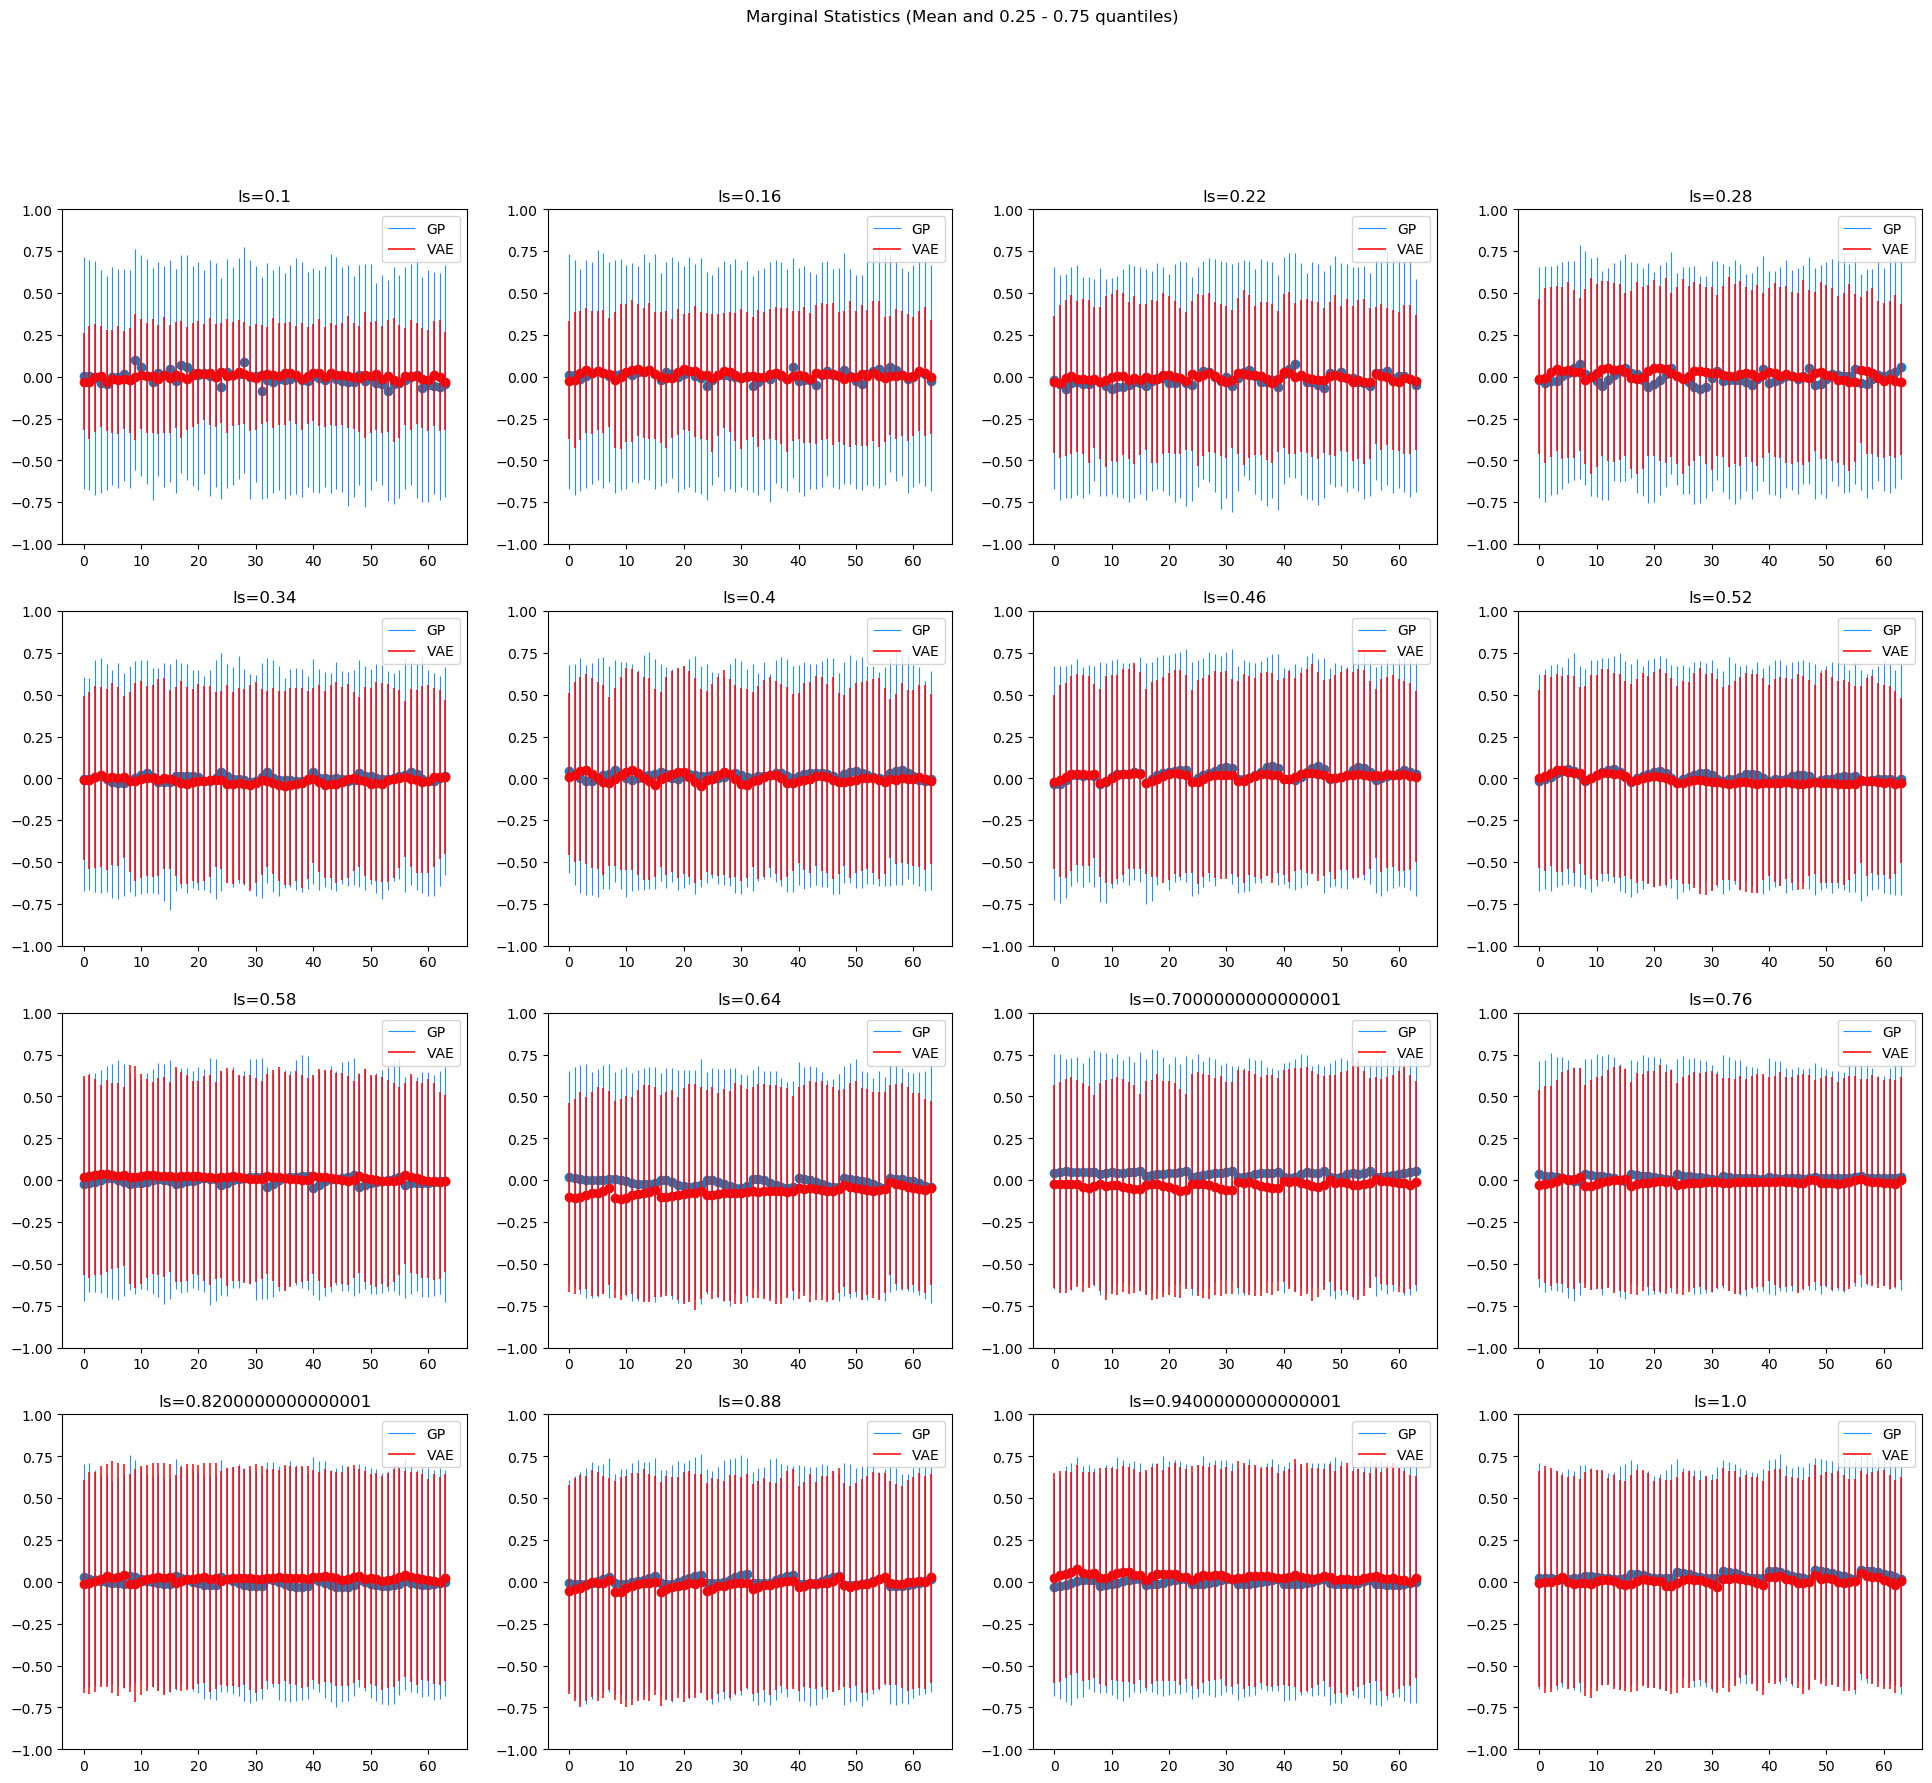

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20))

for i in range(16):
    rows = int(i//4)
    cols = int(i%4)
    
    ls = ls_to_plot[i]
    data_generator.kernel.lengthscale = ls
    
    vae_samps = get_vae_samples(decoder, trained_decoder_params, ls, conditional, n=n_samples)
    _, prior_samples, _ = data_generator.simulatedata(n_samples=n_samples)
    
    gp_samples_mean = jnp.mean(prior_samples, axis=0)
    gp_draws_25, gp_draws_75 = jnp.quantile(prior_samples, jnp.array([.25, .75]), axis=0)

    vae_samples_mean = jnp.mean(vae_samps, axis=0)
    vae_draws_25, vae_draws_75 = jnp.quantile(vae_samps, jnp.array([.25, .75]), axis=0)

    axs[rows][cols].scatter(jnp.arange(len(gp_samples_mean)), gp_samples_mean)
    axs[rows][cols].scatter(jnp.arange(len(vae_samples_mean)), vae_samples_mean, color="red")

    axs[rows][cols].vlines(x=jnp.arange(len(gp_draws_25)),
               ymin=gp_draws_25,
               ymax=gp_draws_75,
               color="dodgerblue",
               label="GP",
               linewidth=0.8)

    axs[rows][cols].vlines(x=jnp.arange(len(vae_draws_25)),
               ymin=vae_draws_25,
               ymax=vae_draws_75,
               color="red",
               label="VAE",
               linewidth=1.1)
    axs[rows][cols].legend()
    axs[rows][cols].set_title(f"ls={round(ls, 2)}")
    axs[rows][cols].set_ylim([-1, 1])

plt.suptitle("Marginal Statistics (Mean and 0.25 - 0.75 quantiles)")
plt.show()

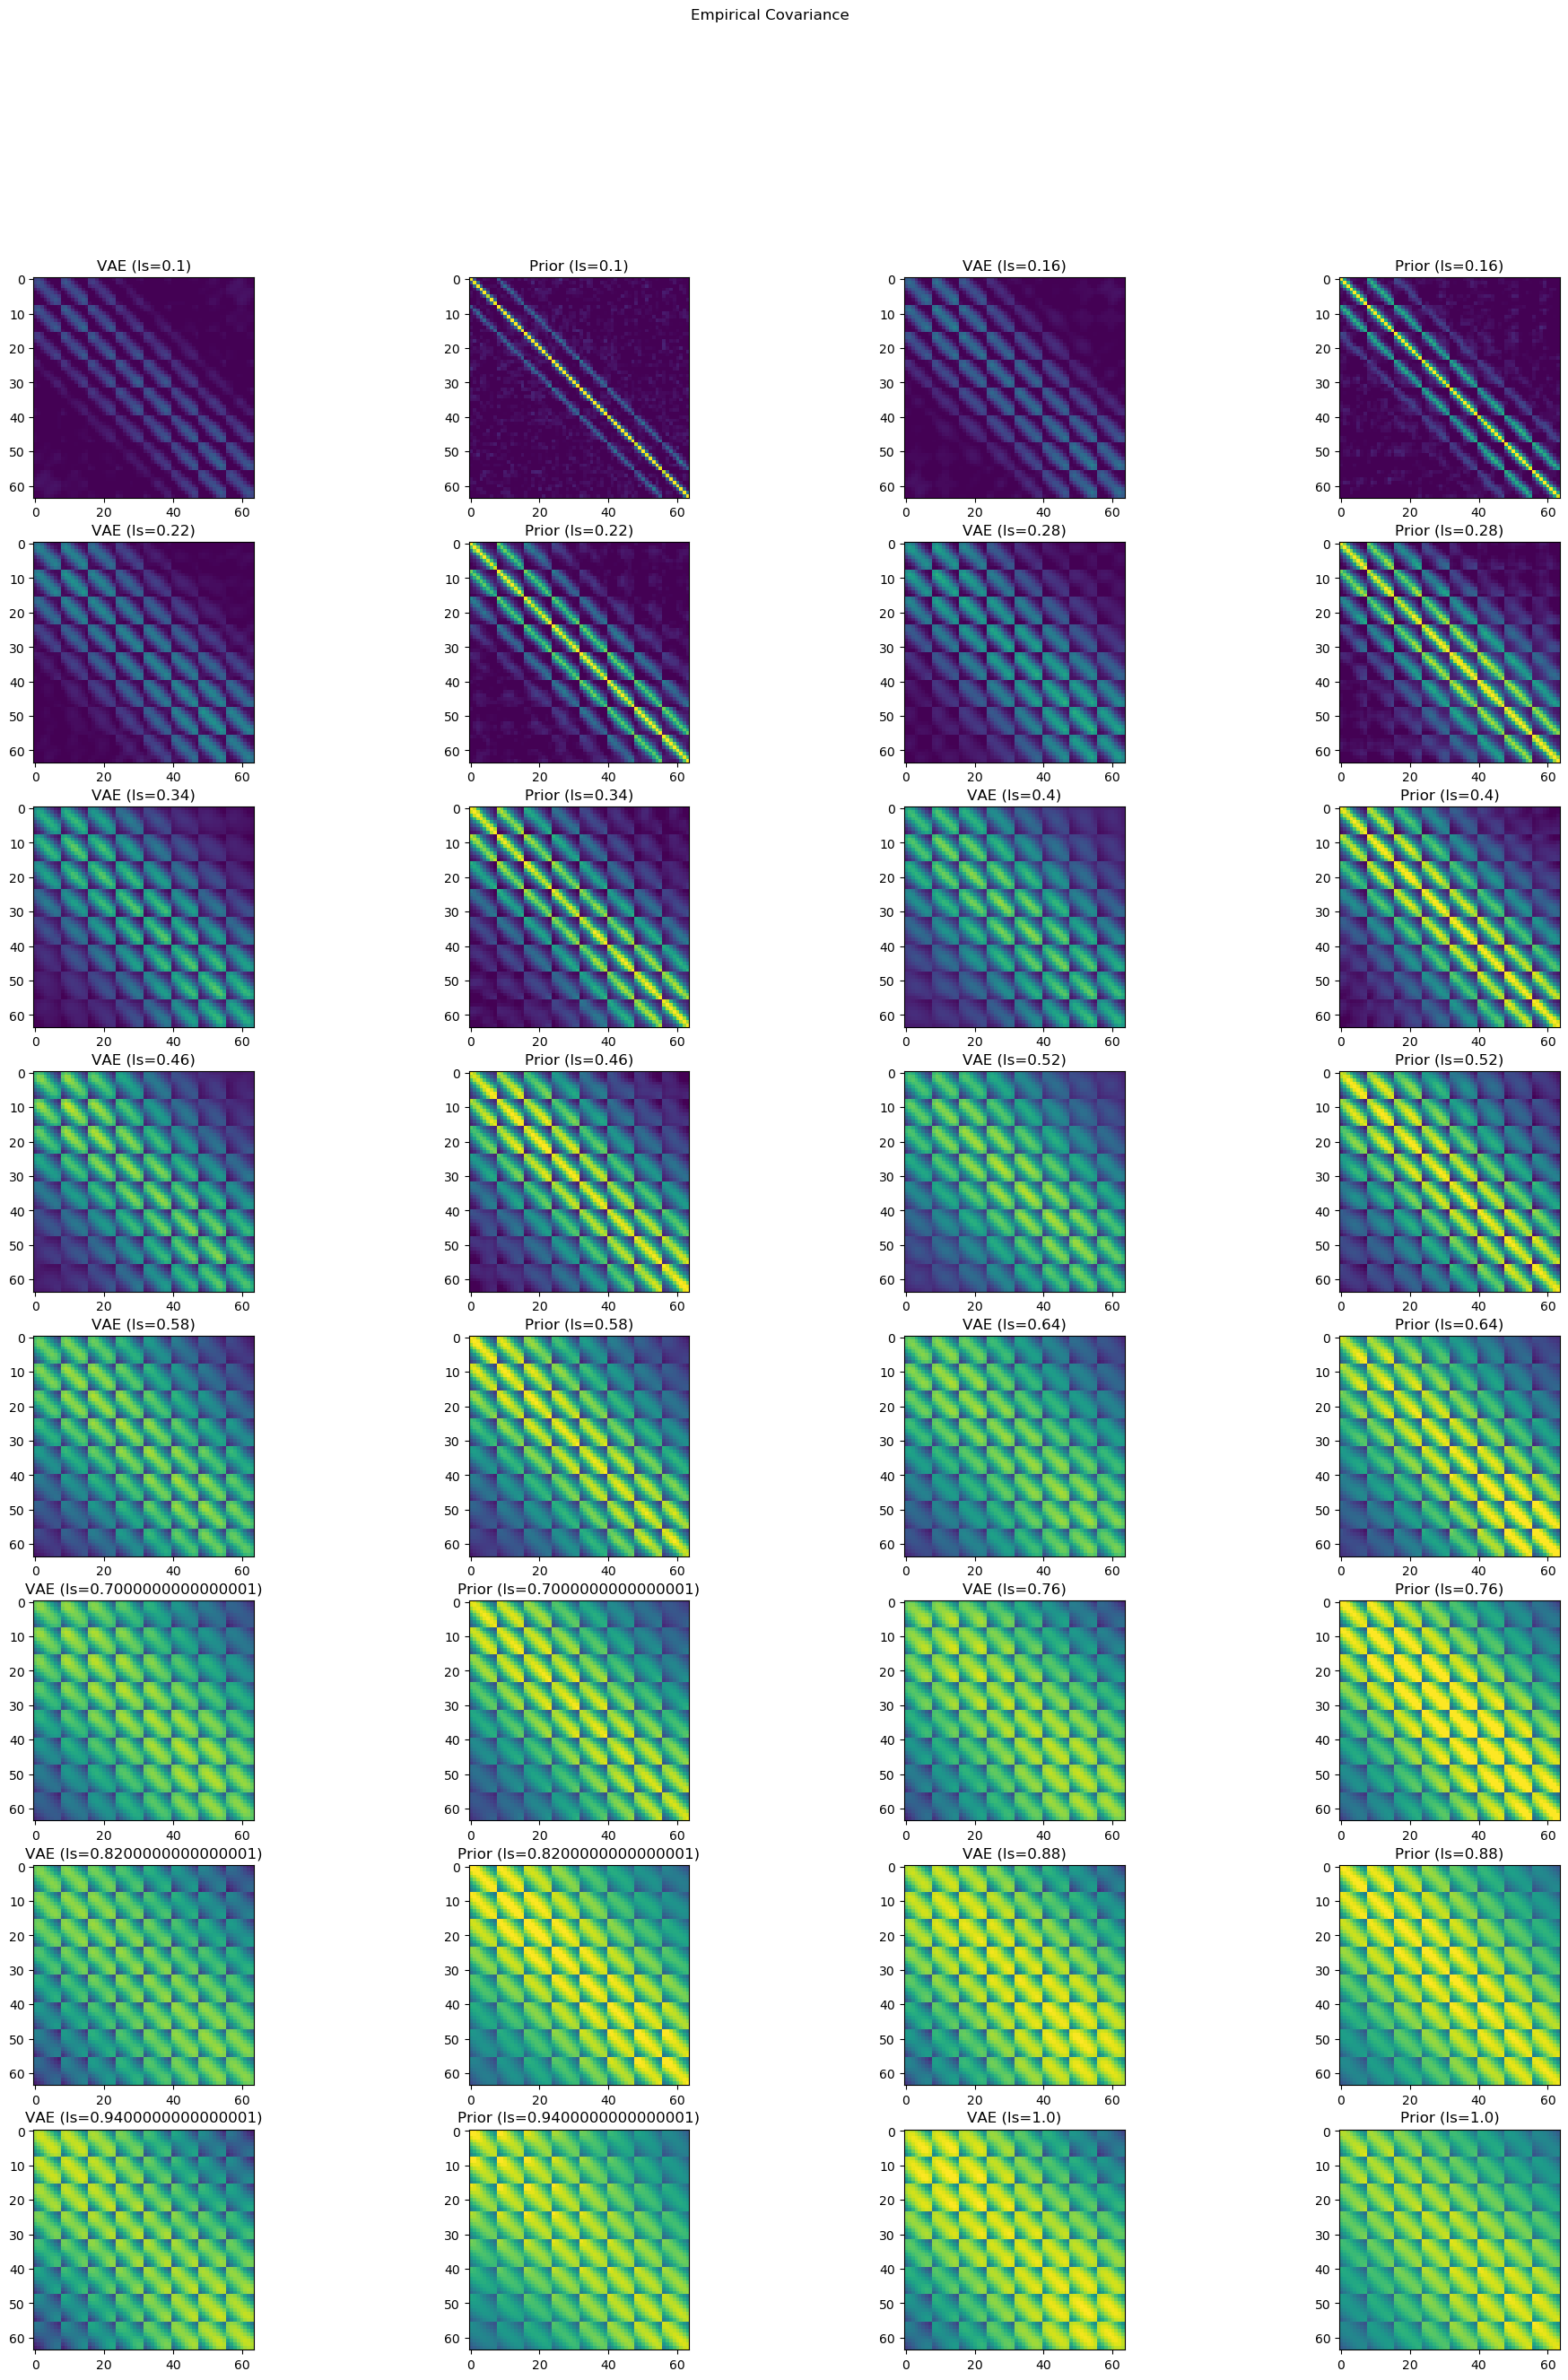

In [9]:
fig, axs = plt.subplots(8, 4, figsize=(24, 30))
cols = 2
for i in range(16):
    rows = int(i//2)
    cols = 0 if cols==2 else 2
    
    ls = ls_to_plot[i]
    data_generator.kernel.lengthscale = ls
    
    vae_samps = get_vae_samples(decoder, trained_decoder_params, ls, conditional, n=n_samples)
    _, prior_samples, _ = data_generator.simulatedata(n_samples=n_samples)
    
    vae_cov = jnp.cov(vae_samps.T)
    prior_cov = jnp.cov(prior_samples.T)
    
    ls = round(ls, 2)
    axs[rows][cols].imshow(vae_cov, vmin=0, vmax=1)
    axs[rows][cols].set_title(f"VAE (ls={ls})")
    axs[rows][cols + 1].imshow(prior_cov, vmin=0, vmax=1)
    axs[rows][cols + 1].set_title(f"Prior (ls={ls})")
    
plt.suptitle("Empirical Covariance")
plt.show()

## Inference

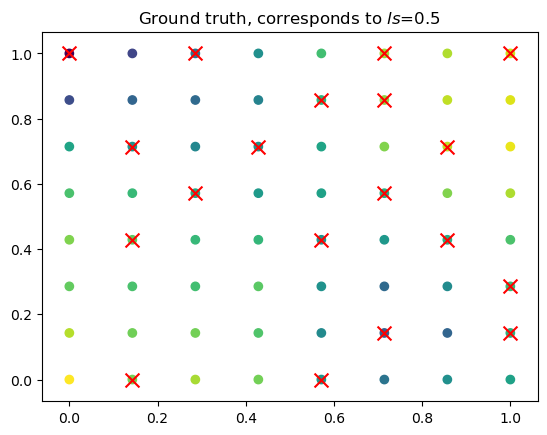

In [10]:
rng_key = jax.random.PRNGKey(8)
rng_key_1, rng_key_2 = jax.random.split(rng_key, 2)

kernel.lengthscale = true_ls
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_1, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# indices of data points
obs_idx = jnp.array([1, 4, 8+5, 8+7, 23, 25, 28, 30, 34, 37, 41, 43, 46, 52, 53, 56, 58, 61, 63])
y_obs = y_draw[obs_idx, 0]
x_obs = x[np.array(obs_idx)]

# plt.figure(figsize=(10, 3))
# plt.plot(x[:, 0], gp_draw, label="ground truth", color="orange")
# plt.scatter(x_obs[:, 0], y_obs, color="red", label="observed data", s=60)
plt.scatter(x[:, 0], x[:, 1], c=y_draw[:, 0], cmap='viridis', marker='o')
#plt.scatter(x_obs[:, 0], x_obs[:, 1], c=y_obs, cmap='jet', marker='x', s=100)
plt.scatter(x_obs[:, 0], x_obs[:, 1], c='red', marker='x', s=100)

plt.title('Ground truth, corresponds to $ls$=' + str(true_ls))
plt.show()


In [11]:
mcmc_args = {
        "num_warmup": 10000,
        "num_mcmc_samples": 100000,
        "num_chains": 3,
        "thinning": 1,
        "x": x,
        "y_obs": y_obs,
        "obs_idx": obs_idx,
        "latent_dim": latent_dim
       }

In [12]:
rng_key_1, rng_key_2 = jax.random.split(rng_key_2, 2)

In [22]:
import numpyro.distributions as npdist

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_1, vae_mcmc_inference_model, mcmc_args, decoder, 
                                                     trained_decoder_params, conditional=conditional,
                                                     c_prior=npdist.Beta(10,10))

  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

In [19]:
#mcmc_gp, mcmc_gp_samples, gp_t_elapsed = run_mcmc_gp(rng_key_1, gp_mcmc_inference_model, mcmc_args, Matern52())

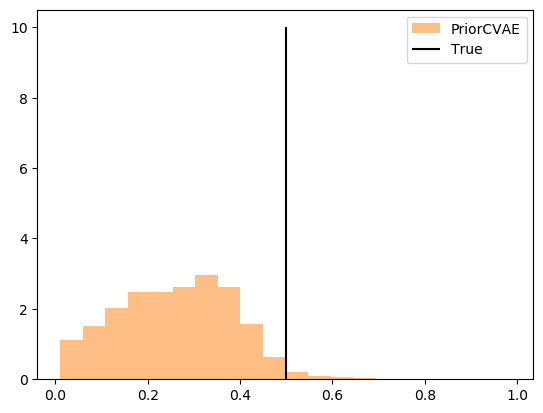

In [20]:
if conditional:
    c_samps = mcmc_vae_samples['c'].reshape((-1,))
    plt.hist(c_samps, density=True, label = 'PriorCVAE', bins=20, color='#ff7f0e', alpha=0.5)
    
    #gp_c_samps = mcmc_gp_samples['ls'].reshape((-1,))
    #plt.hist(gp_c_samps, density=True, label = 'GP', bins=20, color='tab:blue', alpha=0.5)
    
    plt.vlines(true_ls, 0, 10, color="black", label="True")
    #plt.ylim([0, 4])
    plt.legend()
    plt.show()
else:
    c_samps = None

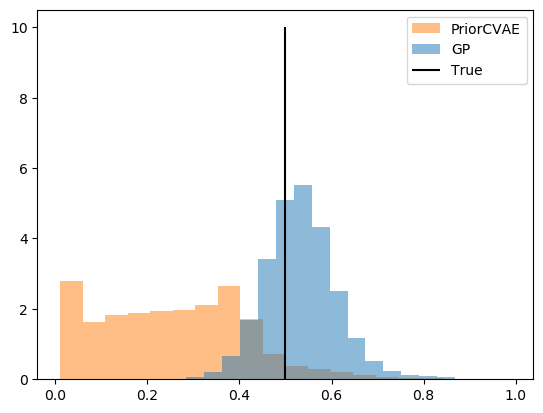

In [45]:
if conditional:
    c_samps = mcmc_vae_samples['c'].reshape((-1,))
    plt.hist(c_samps, density=True, label = 'PriorCVAE', bins=20, color='#ff7f0e', alpha=0.5)
    
    gp_c_samps = mcmc_gp_samples['ls'].reshape((-1,))
    plt.hist(gp_c_samps, density=True, label = 'GP', bins=20, color='tab:blue', alpha=0.5)
    
    plt.vlines(true_ls, 0, 10, color="black", label="True")
    #plt.ylim([0, 4])
    plt.legend()
    plt.show()
else:
    c_samps = None